In [1]:
# standing data tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
# persistence
from sklearn.externals import joblib

plt.style.use('seaborn-white')
%matplotlib inline

In [57]:
# The original 4k: slicer + mesh
data=pd.read_csv('../data/round2/batch1_usable_4k_for_merge.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4628 entries, 0 to 4627
Data columns (total 13 columns):
File                  4628 non-null object
Runtime(s)            4628 non-null int64
Fill Vol(mm^3)        4628 non-null int64
Support Vol(mm^3)     4628 non-null int64
Layer Height(mm)      4628 non-null float64
Mesh Volume(mm^3)     4628 non-null float64
X                     4628 non-null float64
Y                     4628 non-null float64
Z                     4628 non-null float64
BB Vol(mm^3)          4628 non-null float64
CVHull Vol(mm^3)      4628 non-null float64
Surface Area(mm^2)    4628 non-null float64
Euler                 4628 non-null int64
dtypes: float64(8), int64(4), object(1)
memory usage: 506.2+ KB


In [58]:
#Load the updated mesh run with process times
meshdata=pd.read_csv('../data/round2/batch1_usable_4k_trimesh_info_and_runtime.csv')
meshdata.dropna(axis=1,thresh=1,inplace=True)
meshdata.dropna(axis=0,how='any',inplace=True)
meshdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4628 entries, 0 to 4627
Data columns (total 32 columns):
File                4628 non-null object
Load Time           4628 non-null float64
File Size           4628 non-null int64
Time                4628 non-null float64
Watertight          4628 non-null bool
Time.1              4628 non-null float64
X                   4628 non-null float64
Y                   4628 non-null float64
Z                   4628 non-null float64
Time.2              4628 non-null float64
Volume              4628 non-null float64
Time.3              4628 non-null float64
Surface Area        4628 non-null float64
Time.4              4628 non-null float64
BB Vol              4628 non-null float64
Time.5              4628 non-null float64
BC vol              4628 non-null float64
BC rad              4628 non-null float64
Time.6              4628 non-null float64
BS vol              4628 non-null float64
Time.7              4628 non-null float64
min primitive    

In [59]:
#Load the mesh info with magic info
meshdata2=pd.read_csv('../data/round2/batch1_usable_4k_trimesh_info_Jun9_corr_magic.csv')
meshdata2.dropna(axis=1,thresh=1,inplace=True)
meshdata2.dropna(axis=0,how='any',inplace=True)
meshdata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4627 entries, 0 to 4627
Data columns (total 10 columns):
File             4627 non-null object
Load Time        4627 non-null float64
File Size        4627 non-null int64
Time             4627 non-null float64
minz             4627 non-null float64
down area        4627 non-null float64
adj down area    4627 non-null float64
ang down area    4627 non-null float64
magic number     4627 non-null float64
total time       4627 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 397.6+ KB


### “list of viable files” filter:
1. if stl file > 10 MB
2. if !watertight
3. if multiple bodies
4. if mesh.volume < 0
5. mesh.boudning_box.volume < 16387.1 (1 inch^3 cubic of volume)

In [60]:
goodlist=pd.read_csv('../data/round2/viable_meshes_from_10k.csv')
goodlist.dropna(axis=1,thresh=1,inplace=True)
goodlist.dropna(axis=0,how='any',inplace=True)
goodlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3139
Data columns (total 1 columns):
File    3140 non-null object
dtypes: object(1)
memory usage: 49.1+ KB


In [61]:
# Now Merge
mergeddata=pd.merge(data, meshdata, on='File', how='inner')
mergeddata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4628 entries, 0 to 4627
Data columns (total 44 columns):
File                  4628 non-null object
Runtime(s)            4628 non-null int64
Fill Vol(mm^3)        4628 non-null int64
Support Vol(mm^3)     4628 non-null int64
Layer Height(mm)      4628 non-null float64
Mesh Volume(mm^3)     4628 non-null float64
X_x                   4628 non-null float64
Y_x                   4628 non-null float64
Z_x                   4628 non-null float64
BB Vol(mm^3)          4628 non-null float64
CVHull Vol(mm^3)      4628 non-null float64
Surface Area(mm^2)    4628 non-null float64
Euler                 4628 non-null int64
Load Time             4628 non-null float64
File Size             4628 non-null int64
Time                  4628 non-null float64
Watertight            4628 non-null bool
Time.1                4628 non-null float64
X_y                   4628 non-null float64
Y_y                   4628 non-null float64
Z_y                   4628 

In [62]:
mergeddata=pd.merge(mergeddata, meshdata2, on='File', how='inner')
mergeddata.info()
# check
print len(mergeddata)
print len(mergeddata[mergeddata['Watertight']==True])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4627 entries, 0 to 4626
Data columns (total 53 columns):
File                  4627 non-null object
Runtime(s)            4627 non-null int64
Fill Vol(mm^3)        4627 non-null int64
Support Vol(mm^3)     4627 non-null int64
Layer Height(mm)      4627 non-null float64
Mesh Volume(mm^3)     4627 non-null float64
X_x                   4627 non-null float64
Y_x                   4627 non-null float64
Z_x                   4627 non-null float64
BB Vol(mm^3)          4627 non-null float64
CVHull Vol(mm^3)      4627 non-null float64
Surface Area(mm^2)    4627 non-null float64
Euler                 4627 non-null int64
Load Time_x           4627 non-null float64
File Size_x           4627 non-null int64
Time_x                4627 non-null float64
Watertight            4627 non-null bool
Time.1                4627 non-null float64
X_y                   4627 non-null float64
Y_y                   4627 non-null float64
Z_y                   4627 

In [63]:
# Now Apply Good file Filter
mergeddata=pd.merge(mergeddata, goodlist, on='File', how='inner')
mergeddata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1478 entries, 0 to 1477
Data columns (total 53 columns):
File                  1478 non-null object
Runtime(s)            1478 non-null int64
Fill Vol(mm^3)        1478 non-null int64
Support Vol(mm^3)     1478 non-null int64
Layer Height(mm)      1478 non-null float64
Mesh Volume(mm^3)     1478 non-null float64
X_x                   1478 non-null float64
Y_x                   1478 non-null float64
Z_x                   1478 non-null float64
BB Vol(mm^3)          1478 non-null float64
CVHull Vol(mm^3)      1478 non-null float64
Surface Area(mm^2)    1478 non-null float64
Euler                 1478 non-null int64
Load Time_x           1478 non-null float64
File Size_x           1478 non-null int64
Time_x                1478 non-null float64
Watertight            1478 non-null bool
Time.1                1478 non-null float64
X_y                   1478 non-null float64
Y_y                   1478 non-null float64
Z_y                   1478 

In [64]:
# finally export
mergeddata.to_csv('../data/round2/batch1_usable_goodlist_corrmag.csv')

In [65]:
# check
print len(mergeddata)
sd=mergeddata[mergeddata['Watertight']==True]
print len(sd)

1478
1478


In [8]:
# The full sim dataset
slicerall=pd.read_csv('../data/round2/batch2_all_viable_cura_info.csv')
slicerall.dropna(inplace=True)
slicerall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054 entries, 0 to 3139
Data columns (total 7 columns):
File                  3054 non-null object
Output                3054 non-null object
Cura Setting          3054 non-null object
Layer Height          3054 non-null float64
Runtime (s)           3054 non-null int64
Fill Vol (mm^3)       3054 non-null int64
Support Vol (mm^3)    3054 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 190.9+ KB


In [3]:
# The full mesh dataset
meshall=pd.read_csv('../data/round2/batch2_all_viable_trimesh_info.csv')
meshall.dropna(axis=1,thresh=1,inplace=True)
meshall.dropna(axis=0,how='any',inplace=True)
meshall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3139 entries, 0 to 3139
Data columns (total 36 columns):
File             3139 non-null object
Load Time        3139 non-null float64
File Size        3139 non-null int64
Time             3139 non-null float64
Watertight       3139 non-null bool
Time.1           3139 non-null float64
NumBodies        3139 non-null float64
Time.2           3139 non-null float64
minZ             3139 non-null float64
Time.3           3139 non-null float64
X                3139 non-null float64
Y                3139 non-null float64
Z                3139 non-null float64
Time.4           3139 non-null float64
Volume           3139 non-null float64
Time.5           3139 non-null float64
Surface Area     3139 non-null float64
Time.6           3139 non-null float64
BB Vol           3139 non-null float64
Time.7           3139 non-null float64
BC vol           3139 non-null float64
BC rad           3139 non-null float64
Time.8           3139 non-null float64
BS

In [5]:
# Now Merge
mergedall=pd.merge(slicerall, meshall, on='File', how='inner')
mergedall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050 entries, 0 to 3049
Data columns (total 42 columns):
File                  3050 non-null object
Output                3050 non-null object
Cura Setting          3050 non-null object
Layer Height          3050 non-null float64
Runtime (s)           3050 non-null int64
Fill Vol (mm^3)       3050 non-null int64
Support Vol (mm^3)    3050 non-null float64
Load Time             3050 non-null float64
File Size             3050 non-null int64
Time                  3050 non-null float64
Watertight            3050 non-null bool
Time.1                3050 non-null float64
NumBodies             3050 non-null float64
Time.2                3050 non-null float64
minZ                  3050 non-null float64
Time.3                3050 non-null float64
X                     3050 non-null float64
Y                     3050 non-null float64
Z                     3050 non-null float64
Time.4                3050 non-null float64
Volume                305

In [6]:
mergedall.to_csv('../data/round2/batch2_all_viable_merged_v2.csv')

In [10]:
# standing data tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
#Load the dataset
data=pd.read_csv('../data/round2/batch2_all_viable_merged_v2.csv')
from TDPPredictor import *
setup_df(data)

#filter dataset
Vmin=1.
Vmax=2000.
anafilter=(data['Vmes']>Vmin)&(data['Vmes']<Vmax)&(data['Watertight']==True)&( (data['t']/data['Vmes'])<100)
sd=data[anafilter]

# cut numbers
ndata=len(data)
nselected=len(sd)
ntrain=np.int(nselected*0.6)
nval=np.int(nselected*0.3)
nholdout=np.int(nselected*0.1)
print 'total input:', ndata, 'total selected:', nselected, 'selection efficiency:', np.divide(nselected,np.float(ndata))
# test first on the training set
sd_test_train = sd.head(ntrain+nval)
sd_train = sd_test_train.head(ntrain)
sd_test = sd_test_train.tail(nval)
sd_holdout = sd.tail(nholdout)
print 'train on:',len(sd_train), 'testing on:',len(sd_test), 'hold-out:', len(sd_holdout)

before conversion: 28401
after conversion: 473.35
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Data columns (total 53 columns):
Unnamed: 0       3050 non-null int64
File             3050 non-null object
Output           3050 non-null object
Cura Setting     3050 non-null object
dh               3050 non-null float64
t                3050 non-null float64
Vfil             3050 non-null float64
Vsup             3050 non-null float64
Load Time        3050 non-null float64
File Size        3050 non-null int64
Time             3050 non-null float64
Watertight       3050 non-null bool
Time.1           3050 non-null float64
NumBodies        3050 non-null float64
Time.2           3050 non-null float64
minZ             3050 non-null float64
Time.3           3050 non-null float64
X                3050 non-null float64
Y                3050 non-null float64
Z                3050 non-null float64
Time.4           3050 non-null float64
Vmes             3050 non-null flo

In [23]:
sd_train.to_csv('../data/round2/batch2_all_viable_merged_train.csv')
sd_test.to_csv('../data/round2/batch2_all_viable_merged_test.csv')
sd_holdout.to_csv('../data/round2/batch2_all_viable_merged_holdout.csv')

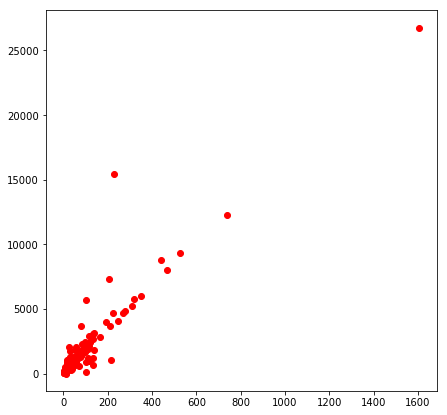

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.scatter(sd_holdout["Vmes"],sd_holdout["t"],color='red')